In [1]:
import pandas as pd
df = pd.read_csv('training_data.csv')
raw_df = pd.read_csv('data/data.csv')

In [2]:
# Divide the data into features (X) and target variable (Y)
# For time series data, we need to be careful about the order of data

# First, let's sort the data by timestamp to ensure chronological order
df = df.sort_values('date_hour')

# Define the target variable (Y) - equipment energy consumption
y = df['equipment_energy_consumption']

# Define the features (X) - all columns except the target
# For time series modeling, we'll keep timestamp as a feature for now
X = df.drop(columns=['equipment_energy_consumption'])

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Display first few rows of features and target
print("\nFirst few rows of features (X):")
print(X.head())

print("\nFirst few rows of target (y):")
print(y.head())

# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Since this is time series data, we should split the data chronologically
# We'll use the train_test_split function but maintain the time order
# by setting shuffle=False
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("\nTraining set sizes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("\nTest set sizes:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Features (X) shape: (1829, 12)
Target (y) shape: (1829,)

First few rows of features (X):
             date_hour  lighting_energy  zone1_temp_humid  zone2_temp_humid  \
0  2016-01-11 17:00:00            180.0       1048.856621        856.201600   
1  2016-01-11 18:00:00            270.0        915.001216        858.950087   
2  2016-01-11 20:00:00            210.0       1009.758858        922.715005   
3  2016-01-11 21:00:00            120.0        794.091181        924.233500   
4  2016-01-11 23:00:00             80.0        953.551583        922.616985   

   zone3_temp_humid  zone4_temp_humid  zone5_temp_humid  zone6_temp_humid  \
0        889.191087       1040.918199        961.902510        547.581986   
1        887.597084       1029.361346        940.044000        539.884267   
2        955.488068        944.724744       1304.040432        474.348249   
3        938.242075        945.339794       1305.655587        481.339012   
4        929.792842        974.557672        983.5


Training Random Forest...
Random Forest - Training RMSE: 176.84, Test RMSE: 415.45
Random Forest - Training R²: 0.8815, Test R²: 0.0306
Random Forest - Test MAE: 302.59

Training Gradient Boosting...
Gradient Boosting - Training RMSE: 357.75, Test RMSE: 408.47
Gradient Boosting - Training R²: 0.5152, Test R²: 0.0629
Gradient Boosting - Test MAE: 276.97

Model Comparison:
           Random Forest  Gradient Boosting
Test RMSE     415.449570         408.466087
Test R²         0.030559           0.062876
Test MAE      302.594433         276.968613


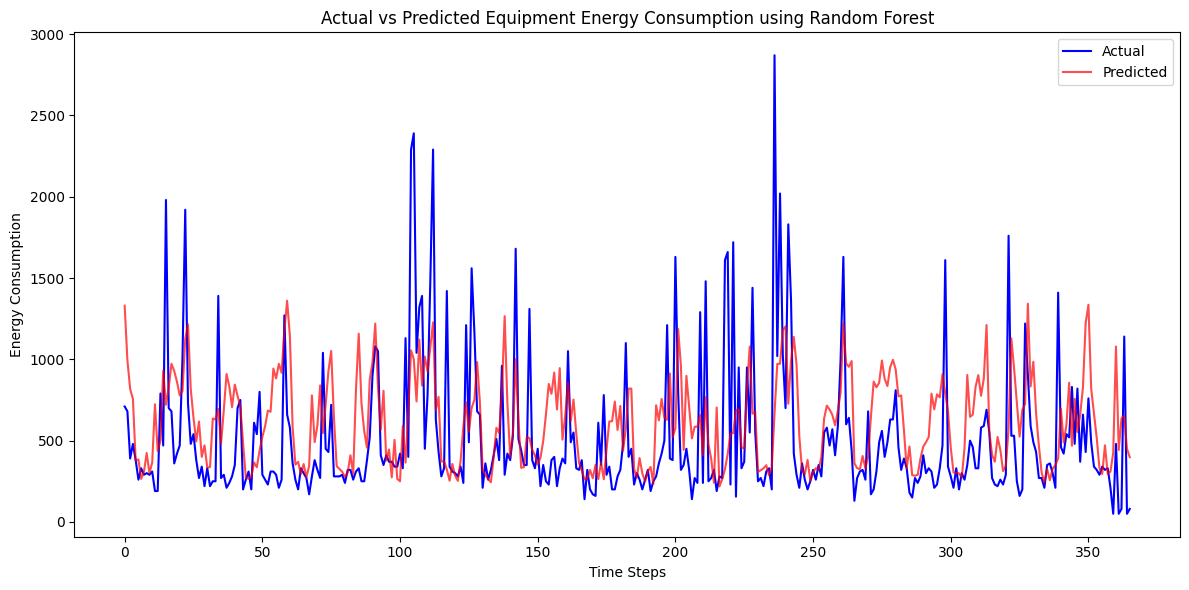

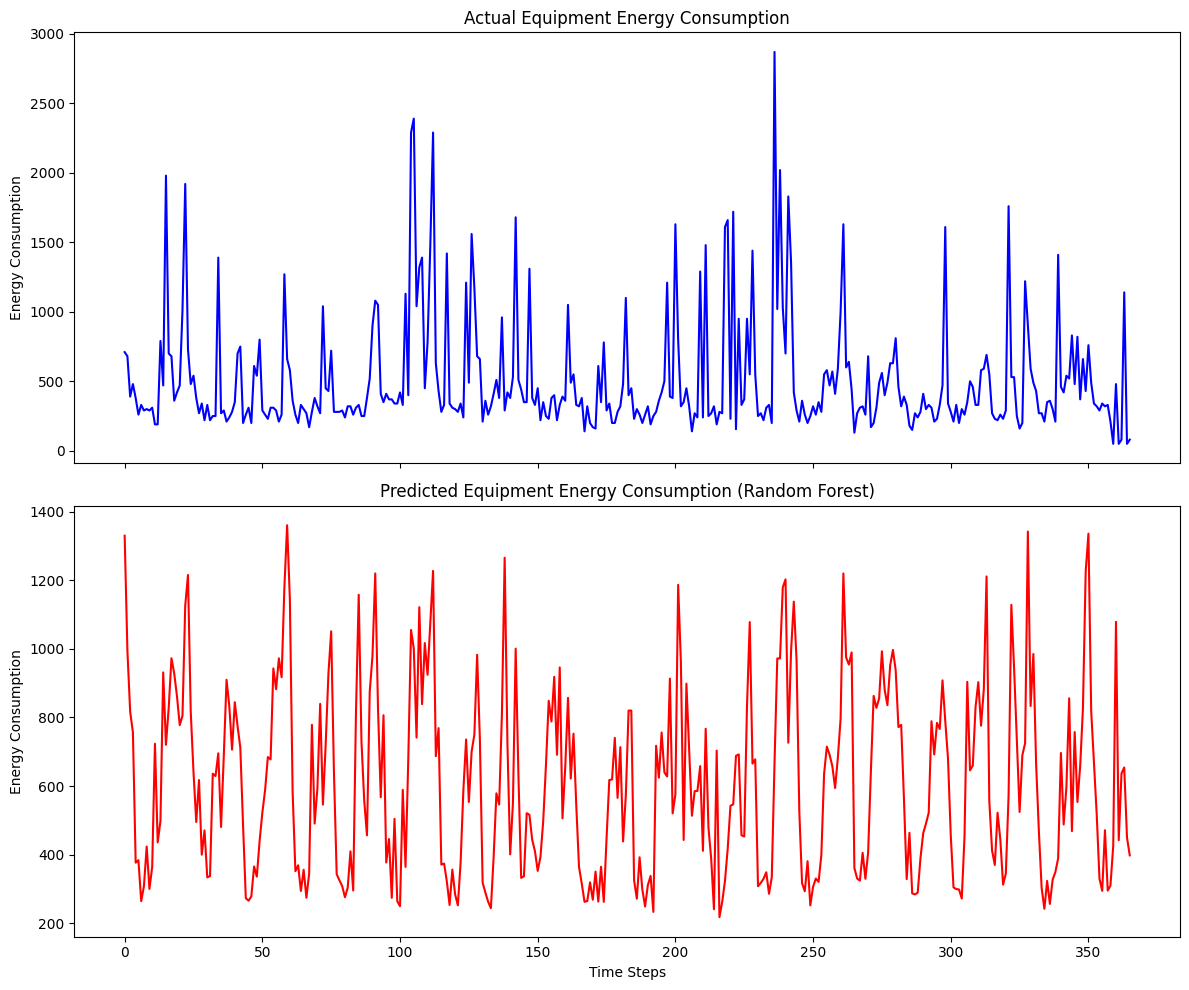

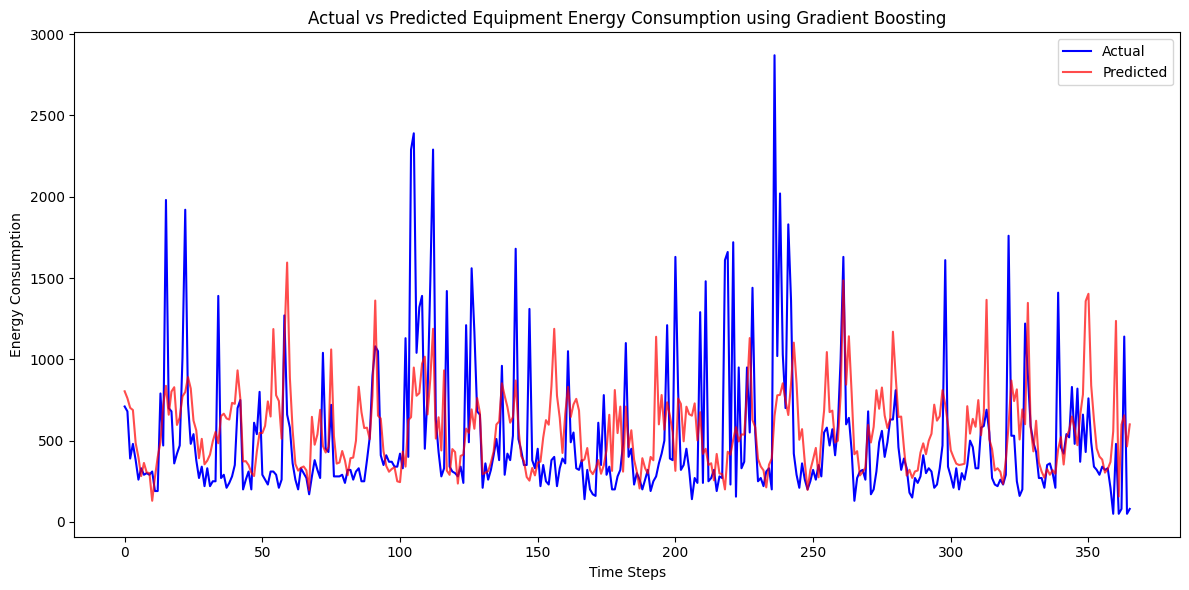

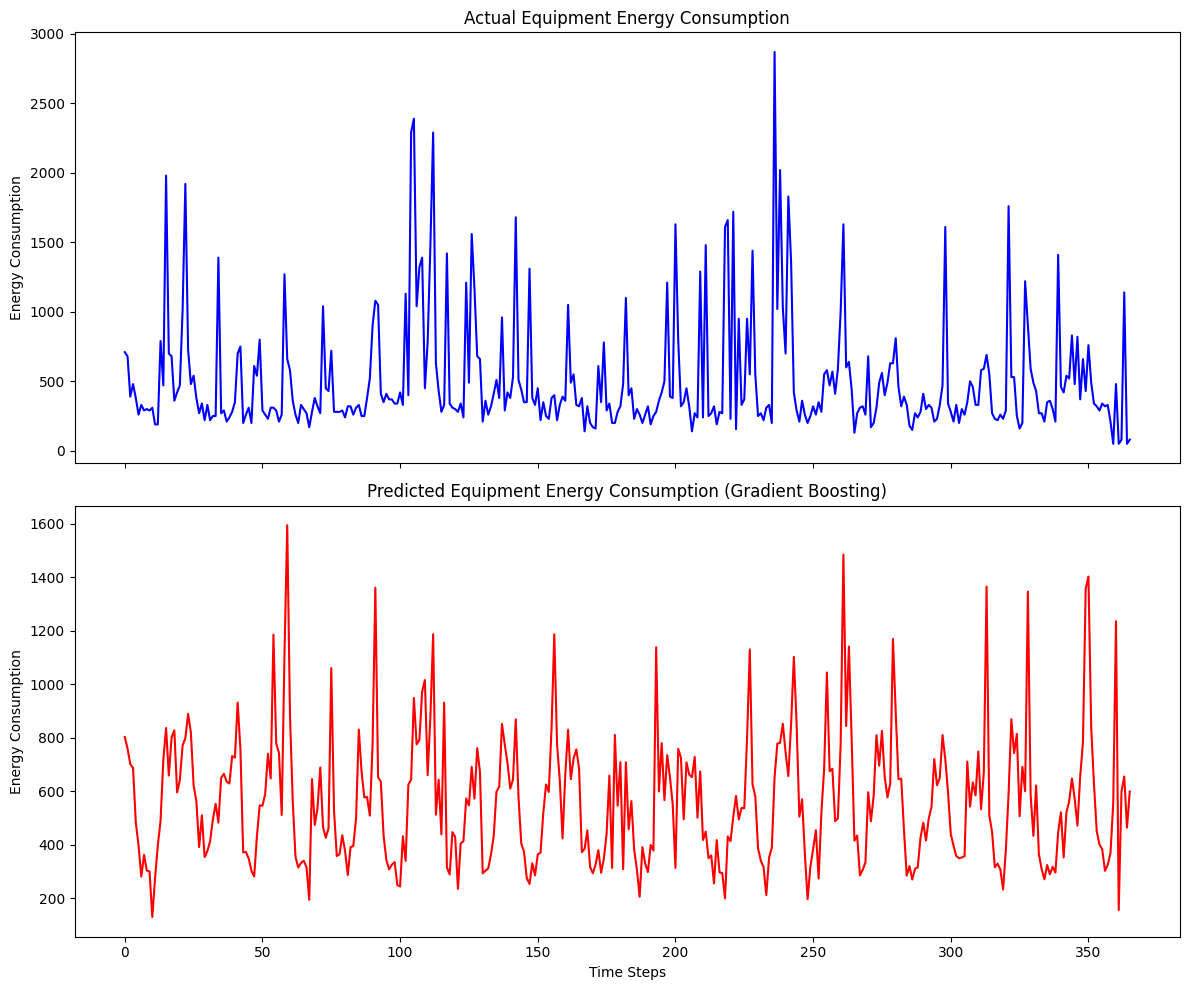

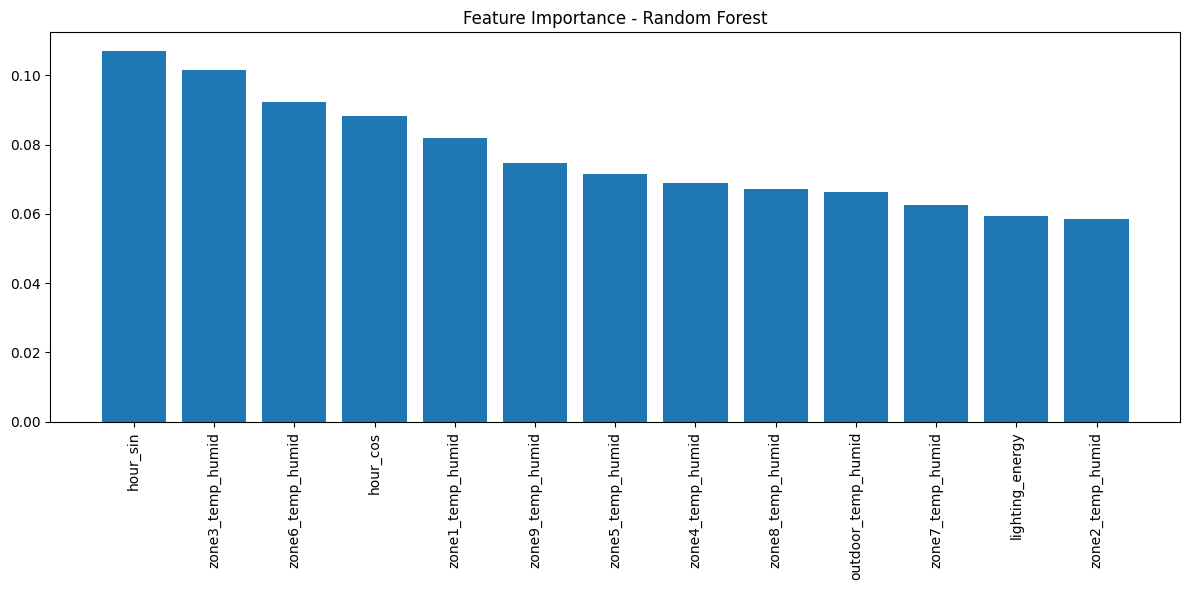

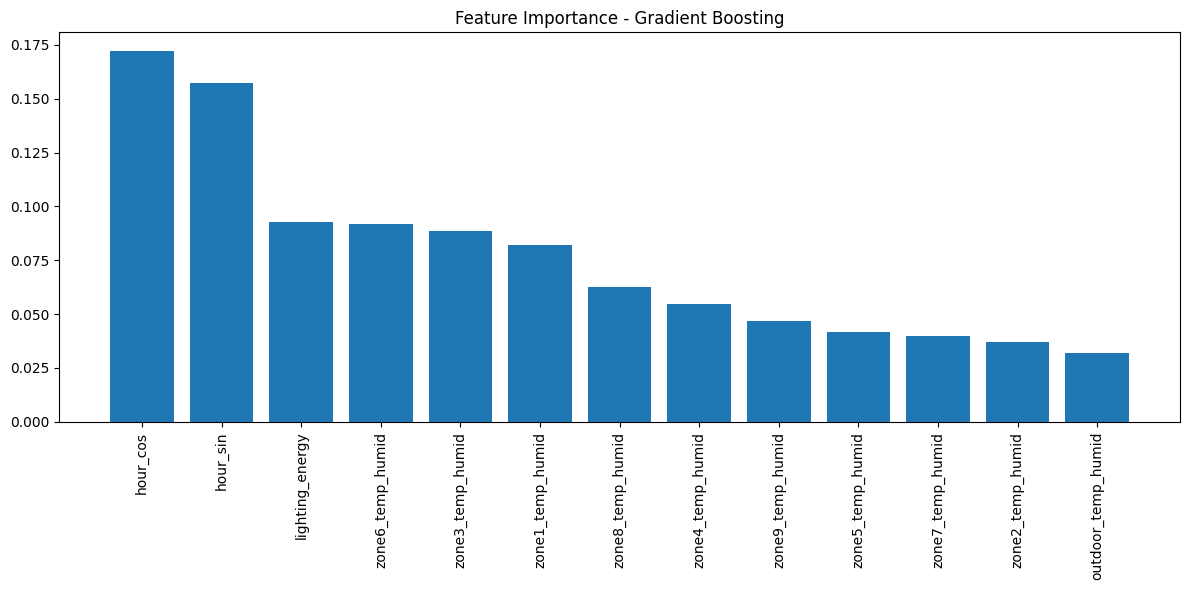

In [4]:
# Import necessary libraries for regression modeling and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# First, let's handle the date_hour column for modeling
# We'll extract useful time features
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Convert date_hour to datetime type first
X_train_processed['date_hour'] = pd.to_datetime(X_train_processed['date_hour'])
X_test_processed['date_hour'] = pd.to_datetime(X_test_processed['date_hour'])

# Extract time-based features
X_train_processed['hour'] = X_train_processed['date_hour'].dt.hour
X_test_processed['hour'] = X_test_processed['date_hour'].dt.hour

# Add cyclical time features for hour
# Convert hour to its cyclical representation using sine and cosine transformations
X_train_processed['hour_sin'] = np.sin(2 * np.pi * X_train_processed['hour']/24.0)  # Using 24.0 since hours range from 0-23
X_train_processed['hour_cos'] = np.cos(2 * np.pi * X_train_processed['hour']/24.0)
X_test_processed['hour_sin'] = np.sin(2 * np.pi * X_test_processed['hour']/24.0)
X_test_processed['hour_cos'] = np.cos(2 * np.pi * X_test_processed['hour']/24.0)

# Drop the original timestamp column and the raw hour column since we have better cyclical representations
X_train_processed = X_train_processed.drop(columns=['date_hour', 'hour'])
X_test_processed = X_test_processed.drop(columns=['date_hour', 'hour'])

# Apply scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Initialize and train different regression models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}
predictions = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Store predictions for later visualization
    predictions[name] = y_test_pred
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae
    }
    
    # Print metrics
    print(f"{name} - Training RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"{name} - Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"{name} - Test MAE: {test_mae:.2f}")

# Create a comparison table of model performance
import pandas as pd
results_df = pd.DataFrame({
    model_name: {
        'Test RMSE': results[model_name]['test_rmse'],
        'Test R²': results[model_name]['test_r2'],
        'Test MAE': results[model_name]['test_mae']
    } for model_name in results
})

print("\nModel Comparison:")
print(results_df)

# Plot actual vs predicted for each model on separate graphs
for name, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted Equipment Energy Consumption using {name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Also plot them on separate subplots for better comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Actual values
    ax1.plot(y_test.values, color='blue')
    ax1.set_title('Actual Equipment Energy Consumption')
    ax1.set_ylabel('Energy Consumption')
    
    # Predicted values
    ax2.plot(y_pred, color='red')
    ax2.set_title(f'Predicted Equipment Energy Consumption ({name})')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Energy Consumption')
    
    plt.tight_layout()
    plt.show()

# Feature importance for tree-based models
for model_name in ['Random Forest', 'Gradient Boosting']:
    if model_name in models:
        model = models[model_name]
        feature_importance = model.feature_importances_
        feature_names = X_train_processed.columns
        
        # Sort features by importance
        indices = np.argsort(feature_importance)[::-1]
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importance - {model_name}')
        plt.bar(range(len(indices)), feature_importance[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()